In [13]:
pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 25.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [67]:
import os
import pandas as pd

# Définir les répertoires
nok_nok_dir = '/Users/tourgismacbook/Downloads/etc/mip/qoe_attachment_classify/output/NOK_NOK'
nok_ok_dir = '/Users/tourgismacbook/Downloads/etc/mip/qoe_attachment_classify/output/NOK_OK'
script_dir = '/Users/tourgismacbook/Downloads/etc/mip/qoe_attachment_classify/output/NOK_NOK'  # Répertoire contenant les fichiers .script.txt

# Initialiser une liste pour les données
data = []

# Table de correspondance entre descriptions actuelles et descriptions finales
description_mapping = {
    "> Step not count - Write mail": "Write mail",
    "Step not count - Write mail": "Write mail",
    "> Step not count - Load Mail Boxes": "Load Mail Boxes",
    "> Step Finalize - Close MailBox 1": "Close MailBox",
    ">  > Step Finalize - Close MailBox 1": "Close MailBox",
    "Step 2 - Check mail received": "Check mail received",
    "Step 1 - Clean Mail Boxes": "Clean Mail Boxes",
    "> Step 1 - Clean Mail Boxes": "Clean Mail Boxes",
    ">  > Step Finalize - Close MailBox 2": "Close MailBox",
    "> Step Finalize - Close MailBox 2" : "Close MailBox",
    "Step 1 - Send mail": "Send mail",
    "> Step 2 - Check mail received" : "Check mail received",
    "Step not count - Load Mail Boxes": "Load Mail Boxes"
}

# Table de correspondance entre descriptions et classes
description_to_class = {
    "Write mail": 1,
    "Load Mail Boxes": 2,
    "Close MailBox": 3,
    "Check mail received": 4,  # Regroupé dans la classe 7
    "Clean Mail Boxes": 4,     # Regroupé dans la classe 7
    "Send mail": 3
}

null_class = 0

# Fonction pour associer un fichier script à une image
def get_script_path(image_path):
    """
    Trouve le chemin du fichier script associé à une image donnée.
    """
    base_name = os.path.splitext(os.path.basename(image_path))[0]  # Nom de base de l'image sans extension
    script_name = f"{base_name}.script.txt"  # Construire le nom du fichier script
    script_path = os.path.join(script_dir, script_name)  # Construire le chemin complet
    return script_path if os.path.exists(script_path) else None  # Vérifier si le fichier existe

# Fonction pour extraire la description et assigner une classe
def parse_script(script_path):
    """
    Analyse le fichier script pour trouver la ligne contenant '- fail',
    extrait la description (entre le deuxième '-' et 'executed') et assigne une classe fixe.
    """
    if not script_path or not os.path.exists(script_path):
        return None, null_class  # Si le fichier script est absent, retourne une classe null
    
    with open(script_path, 'r') as file:
        for line in file:
            if "- fail" in line:  # Recherche la ligne contenant '- fail'
                # Extraire la partie entre le deuxième '-' et 'executed'
                try:
                    start = line.split("-", 2)[-1].strip()  # Prend tout après le deuxième '-'
                    end = start.split(" executed", 1)[0].strip()  # Stoppe avant 'executed'
                    description = end
                    # Remplacer la description selon le mapping
                    description = description_mapping.get(description, description)
                    # Récupérer la classe associée
                    class_id = description_to_class.get(description, null_class)  # Si description inconnue, classe null
                    return description, class_id
                except IndexError:
                    continue  # En cas d'erreur dans le format, passer à la ligne suivante
    return None, null_class  # Si aucune ligne '- fail' n'est trouvée

# Parcourir le dossier NOK_NOK et ajouter les données
for file in os.listdir(nok_nok_dir):
    if file.endswith(".png"):  # Vérifier si c'est une image PNG
        file_path = os.path.join(nok_nok_dir, file)  # Chemin complet de l'image
        script_path = get_script_path(file_path)  # Trouver le script associé
        description, class_id = parse_script(script_path)  # Extraire description et classe
        if description:  # Si une description a été trouvée
            data.append({
                "path": file_path,
                "script_path": script_path,
                "description": description,
                "class": class_id  # Ajouter la classe
            })

# Ajouter les images de NOK_OK avec description et classe nulles
for file in os.listdir(nok_ok_dir):
    if file.endswith(".png"):  # Vérifier si c'est une image PNG
        file_path = os.path.join(nok_ok_dir, file)  # Chemin complet de l'image
        data.append({
            "path": file_path,
            "script_path": None,  # Pas de script pour ce répertoire
            "description": None,  # Pas de description pour ces images
            "class": null_class  # Classe null pour ces images
        })

# Convertir en DataFrame pandas
df = pd.DataFrame(data)

# Sauvegarder dans un fichier CSV
output_csv = "images_with_updated_classes.csv"
df.to_csv(output_csv, index=False)

print(f"Fichier CSV généré avec les descriptions et classes mises à jour : {output_csv}")


Fichier CSV généré avec les descriptions et classes mises à jour : images_with_updated_classes.csv


In [69]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

data = pd.read_csv('images_with_updated_classes.csv')

data['description'] = data['description'].fillna('unknown') 

# Taille des images
IMAGE_SIZE = (128, 128)

# Préparation des images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img) / 255.0  # Normaliser entre 0 et 1
    return img_array

# encodage
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['description'])
sequences = tokenizer.texts_to_sequences(data['description'])
word_index = tokenizer.word_index
padded_sequences = pad_sequences(sequences, maxlen=10)  # Limiter à 10 mots max

# Charger les images et les descriptions
images = np.array([preprocess_image(path) for path in data['path']])
text_data = np.array(padded_sequences)
labels = np.array(data['class'])

X_train_img, X_test_img, X_train_txt, X_test_txt, y_train, y_test = train_test_split(
    images, text_data, labels, test_size=0.2, random_state=42
)


In [72]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Embedding, LSTM, concatenate

# entrée images
image_input = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
image_output = Dense(128, activation='relu')(x)

# Entrée texte
text_input = Input(shape=(10,))
y = Embedding(input_dim=len(word_index) + 1, output_dim=50)(text_input)
y = LSTM(64)(y)
text_output = Dense(128, activation='relu')(y)

# Fusionner les deux sorties
combined = concatenate([image_output, text_output])
z = Dense(64, activation='relu')(combined)
z = Dense(5, activation='softmax')(z)  # 5 classes au total (0, 1, 2, 3, 4)

# Modèle final
model = Model(inputs=[image_input, text_input], outputs=z)

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 126, 126,  │        896 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 63, 63,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_16… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 30, 30,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 10, 50)    │        600 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 57600)     │          0 │ max_pooling2d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     29,440 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │  7,372,928 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │      8,320 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ dense_16[0][0],   │
│ (Concatenate)       │                   │            │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │     16,448 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 5)         │        325 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,447,453 (28.41 MB)

 Trainable params: 7,447,453 (28.41 MB)

 Non-trainable params: 0 (0.00 B)

None


In [73]:
# Entraîner le modèle
history = model.fit(
    [X_train_img, X_train_txt], y_train,
    validation_data=([X_test_img, X_test_txt], y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10


/Users/tourgismacbook/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_158', 'keras_tensor_165']. Received: the structure of inputs=('*', '*')
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.3440 - loss: 2.2074 - val_accuracy: 0.4722 - val_loss: 1.5081
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.5161 - loss: 1.3453 - val_accuracy: 0.4722 - val_loss: 1.3705
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.5630 - loss: 1.2017 - val_accuracy: 0.4722 - val_loss: 1.3782
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5551 - loss: 1.1494 - val_accuracy: 0.5833 - val_loss: 1.2714
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.7001 - loss: 0.9788 - val_accuracy: 0.5833 - val_loss: 1.0201
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.7068 - loss: 0.8126 - val_accuracy: 0.6389 - val_loss: 0.9291
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.8448 - loss: 0.4723 - val_accuracy: 0.8056 - val_loss: 0.5528
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9113 - loss: 0.3658 - val_accuracy: 0.7778 - val_loss: 0.5497
Epo

In [74]:
# Évaluer le modèle
test_loss, test_accuracy = model.evaluate([X_test_img, X_test_txt], y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9340 - loss: 0.2931
Test Accuracy: 91.67%


In [83]:
# Exemple de prédiction
def predict(image_path, description):
    img = np.expand_dims(preprocess_image(image_path), axis=0)
    seq = tokenizer.texts_to_sequences([description])
    padded_seq = pad_sequences(seq, maxlen=10)
    prediction = model.predict([img, padded_seq])
    return np.argmax(prediction)

# Exemple d'utilisation
image_path = '/Users/tourgismacbook/Downloads/etc/244_1729096196_01.png'
predicted_class = predict(image_path, description)
print(f"Classe prédite : {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Classe prédite : 1


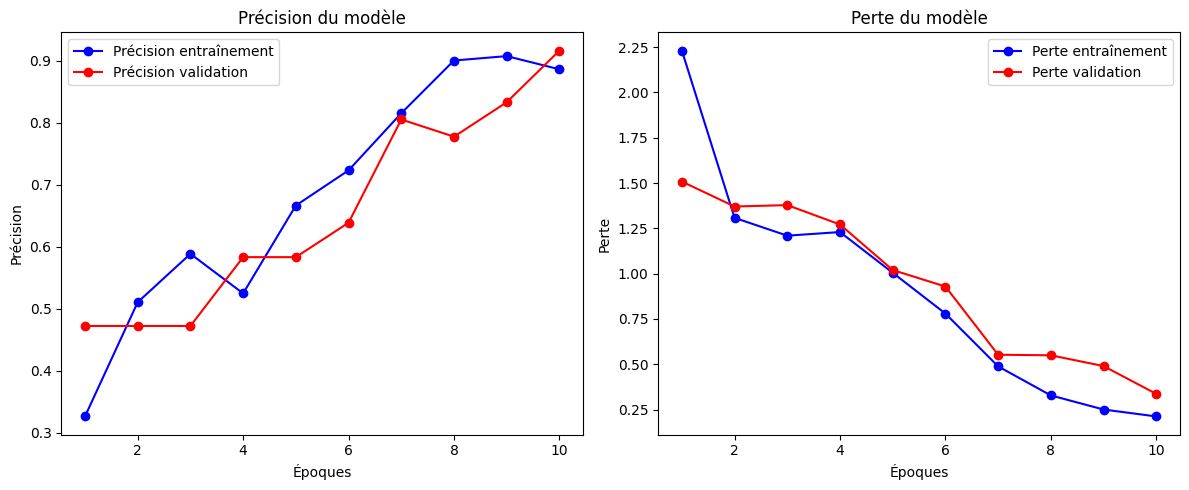

In [84]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Affiche les courbes de précision et de perte à partir de l'historique d'entraînement.
    
    Args:
        history : L'objet History renvoyé par model.fit().
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Précision entraînement')
    plt.plot(epochs, val_acc, 'ro-', label='Précision validation')
    plt.title('Précision du modèle')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Perte entraînement')
    plt.plot(epochs, val_loss, 'ro-', label='Perte validation')
    plt.title('Perte du modèle')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)
